# Lotka-Volterra equations

Solving the Lotka-Volterra equations
$$
\begin{align}
\begin{cases}
\frac{dr}{dt} &= \frac{R}{U}\left(2Ur - 0.04U^2rp\right) \\
\frac{dp}{dt} &= \frac{R}{U}\left(0.02U^2rp - 1.06Up\right)
\end{cases}
\end{align}
$$

used to model the population dynamics of predators and prey and slightly modified to include the upper boundary $U$ of the range and the right boundary $R$ of the range.

We also have the initial conditions
$$
\begin{align*}
r(0) &= \frac{100}{U} &
p(0) &= \frac{15}{U}
\end{align*}
$$
and the parameters
$$
\begin{align*}
U &= 200 & R &= 20
\end{align*}
$$

The reference solution is generated using `integrate.solve_ivp()` from `scipy`

In [1]:
import deepxde as dde
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Define the parameters.

In [2]:
U = 200
R = 20

Define the time domain.

In [3]:
geom = dde.geometry.TimeDomain(0., 1.)

Define the ODE system.

In [4]:
def ode_system(t, y):
	r = y[:, 0:1]
	p = y[:, 1:2]
	dr_dt = dde.grad.jacobian(y, t, i=0)
	dp_dt = dde.grad.jacobian(y, t, i=1)
	return [
		dr_dt - R / U * (2. * U * r - 0.04 * U ** 2 * r * p),
		dp_dt - R / U * (0.02 * U ** 2 * r * p - 1.06 * U * p)
	]

Define the ODE problem without initial conditions (empty list) because since we want hard constraints on the initial conditions we will define them on the network.

In [5]:
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test = 3000)

Define the network.

In [6]:
layer_size = [1] + [50] * 6 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Since we expect to have periodic behavior in the Lotka-Volterra equation, we add a feature layer with $sin(kt)$
. This forces the prediction to be periodic and therefore more accurate

In [7]:
def input_transform(t):
	return tf.concat([
		t,
		tf.sin(t),
		tf.sin(2 * t),
		tf.sin(3 * t),
		tf.sin(4 * t),
		tf.sin(5 * t),
		tf.sin(6 * t),
	], axis=1)


Define the hard constraints on the initial conditions by transforming the output.

In [8]:
def output_transform(t, y):
	r = y[:, 0:1]
	p = y[:, 1:2]
	
	return tf.concat([
		r * tf.tanh(t) + 100 / U,
		p * tf.tanh(t) + 15 / U,
	], axis=1)

Apply these layers to the network.

In [9]:
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

Define and train the model for 10000 iterations.

In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
model.train(iterations=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.059810 s

'compile' took 0.446173 s

Training model...

Step      Train loss              Test loss               Test metric
0         [9.39e+02, 1.09e+01]    [9.40e+02, 1.09e+01]    []  


2024-10-24 14:53:18.719802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


1000      [2.81e+00, 6.51e-01]    [2.70e+00, 6.43e-01]    []  
2000      [1.48e+00, 6.94e-01]    [1.41e+00, 6.80e-01]    []  
3000      [8.84e-01, 5.36e-01]    [8.32e-01, 5.21e-01]    []  
4000      [5.70e-01, 3.69e-01]    [5.42e-01, 3.59e-01]    []  
5000      [3.42e-01, 3.14e-01]    [3.27e-01, 3.04e-01]    []  
6000      [2.25e-01, 2.51e-01]    [2.18e-01, 2.44e-01]    []  
7000      [1.57e-01, 1.91e-01]    [1.54e-01, 1.85e-01]    []  
8000      [9.25e-02, 1.55e-01]    [9.10e-02, 1.52e-01]    []  
9000      [7.53e-02, 1.21e-01]    [7.47e-02, 1.19e-01]    []  
10000     [7.16e-02, 8.82e-02]    [7.14e-02, 8.64e-02]    []  

Best model at step 10000:
  train loss: 1.60e-01
  test loss: 1.58e-01
  test metric: []

'train' took 273.552163 s



(<deepxde.model.LossHistory at 0x1787b08e0>,
 <deepxde.model.TrainState at 0x1787b0220>)

After training with Adam, we continue with L-BFGS to have an even smaller loss:

In [11]:
model.compile("L-BFGS-B")
loss_history, train_state = model.train()

Compiling model...
'compile' took 1.221281 s

Training model...

Step      Train loss              Test loss               Test metric
10000     [7.16e-02, 8.82e-02]    [7.14e-02, 8.64e-02]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.159832
  Number of iterations: 1
  Number of functions evaluations: 35
10035     [7.16e-02, 8.82e-02]    [7.14e-02, 8.64e-02]    []  

Best model at step 10000:
  train loss: 1.60e-01
  test loss: 1.58e-01
  test metric: []

'train' took 2.918662 s



Visualize the loss history and saving the plots.

Saving loss history to /Users/giacomo/dev/notebooks/dde-playground/lotka-volterra/loss.dat ...
Saving training data to /Users/giacomo/dev/notebooks/dde-playground/lotka-volterra/train.dat ...
Saving test data to /Users/giacomo/dev/notebooks/dde-playground/lotka-volterra/test.dat ...


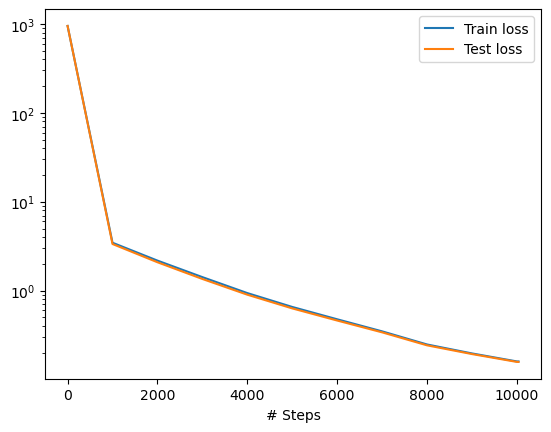

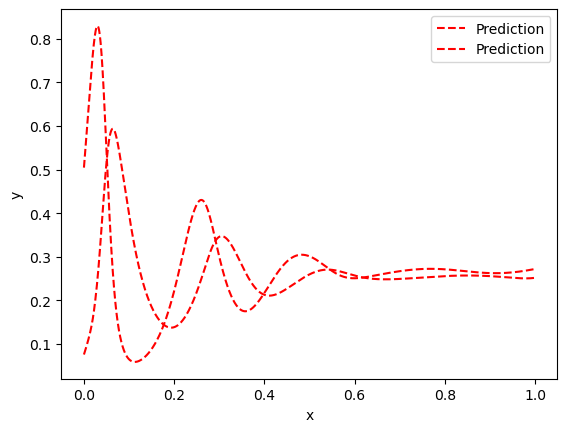

In [12]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)